# Parametric models & Feature Selection
- linear regression 
- linear regression w/ feature selection
- linear regression w/ interaction
- linear regression w/ Ridge, Lasso

모델을 가정하여 데이터가 적은 부분에서도 안정적인 예측력을 보이는 parametric model을 테스트해보았다. 먼저, 가장 기본적인 linear regression에서 시작하여, 모델을 개선시키는 방식으로 진행하였다. 

상호작용이 없는 linear regression의 경우, feature간의 correlation이 없어야하는 가정을 만족해야 하지만, 일종의 벤치마크 수치를 구하기 위해, 모델을 돌려보았다. 

그 다음, backward stepwise selection을 통해 특정 feature의 영향을 제거하여 노이즈를 줄였다. 

그리고, ridge와 lasso를 통해 모든 feature의 영향을 조금씩 줄여 노이즈를 줄여보았다. ridge, lasso의 경우, selected feature를 바탕으로 interaction을 더한 다음, 구한 경우의 성능이 다소 높았다.

**-> 결론: ridge, lasso with interaction of selected features 를 이용하여, 최종 앙상블 모형에 넣기로 결정**

In [1]:
# -*-coding:utf-8 -*-
import pandas as pd
from os import path
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from datetime import datetime
import warnings
import numpy as np
#from numpy import sqrt, mean, log
from random import seed, randrange
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
#LOAD DATA
set_ver = 1
curdir = path.curdir
train_X_file = path.join(curdir, "cache/tr_X_{}.csv.gz".format(set_ver))
test_y_file = path.join(curdir, "cache/tr_y_{}.csv.gz".format(set_ver))
test_X_file = path.join(curdir, "cache/te_X_{}.csv.gz".format(set_ver))

tr_X = pd.read_csv(train_X_file, compression="gzip", index_col="Id")
tr_y = pd.read_csv(test_y_file, compression="gzip", index_col="Id")
te_X = pd.read_csv(test_X_file, compression="gzip", index_col="Id")

print(tr_X.shape, tr_y.shape, te_X.shape)

(1460, 247) (1460, 1) (1459, 247)


In [3]:
#SPLIT CROSS VALIDATION SET
seed(1000)
cv_ref = pd.DataFrame({'Id': tr_X.index})
cv_ref.loc[:, "cv"] = [randrange(5) for i in range(len(tr_X))]
cv_ref.groupby("cv").count()

,Id
cv,
0,290
1,297
2,295
3,297
4,281


In [4]:
tr_y.SalePrice.describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

In [6]:
min_log_saleprice = tr_y.SalePrice.min()

In [8]:
def root_mean_squared_error(y, pred_y):
    assert len(y) == len(pred_y)
    return np.sqrt(sum((pred_y - y)**2.0)/len(y))

def cross_validate(regr, X, y, cv_ref, validation_func, threshold = min_log_saleprice):
    scores = []
    for i in cv_ref.cv.unique():
        regr.fit(X[(cv_ref.cv != i).values], y[(cv_ref.cv != i).values])
        pred_y = regr.predict(X[(cv_ref.cv == i).values])
        # make it 0 for negative predictions
        pred_y[pred_y < threshold] = threshold 
        
        scores.append(
            validation_func(
                y[(cv_ref.cv == i).values].values.reshape(pred_y.shape[0]), 
                pred_y.reshape(pred_y.shape[0])))
    return scores

## Linear Regression

In [9]:
regr = LinearRegression()

In [ ]:
for i in range(10,30):
    rmsle = []
    best_param = 0 
    best_score = 1
    for i in iterable_range:
        cv_scores = cross_validate(
            regr, X, y, cv_table, validation_func, i)
        mean_cv_score = np.mean(cv_scores)
        rmsle.append(mean_cv_score)
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_param = param
        print("i: {} -> rmsle: {}".format(i, mean_cv_score))

In [57]:
#threshold tuning
def threshold_tuning(iterable_range, regr, X, y, cv_table, validation_func):
    rmsle = []
    best_param = 0 
    best_score = 1
    for i in iterable_range:
        cv_scores = cross_validate(
            regr, X, y, cv_table, validation_func, i)
        mean_cv_score = np.mean(cv_scores)
        rmsle.append(mean_cv_score)
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_param = i
        print("i: {} -> rmsle: {}".format(i, mean_cv_score))
    print("best score: {} at {}".format(best_score, best_param))
    plt.plot(iterable_range, rmsle)
    plt.title("Optimal param")
    plt.xlabel("param")
    plt.ylabel("RMSLE")

i: 10.0 -> rmsle: 0.18091293889931878
i: 10.2 -> rmsle: 0.17827085852675864
i: 10.4 -> rmsle: 0.17583399824910678
i: 10.6 -> rmsle: 0.17349802502747844
i: 10.8 -> rmsle: 0.1706162751559641
i: 11.0 -> rmsle: 0.16798370702417026
i: 11.2 -> rmsle: 0.16688230264356793
i: 11.4 -> rmsle: 0.1683395400681145
i: 11.6 -> rmsle: 0.1803671773695959
i: 11.8 -> rmsle: 0.21500090075086858
i: 12.0 -> rmsle: 0.2881643555124787
best score: 0.16688230264356793 at 11.2


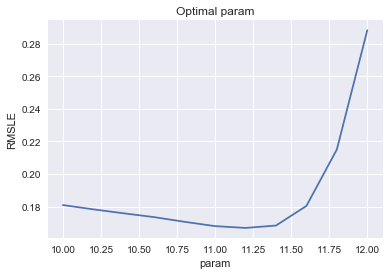

In [58]:
threshold_tuning(np.linspace(10, 12, 11), regr, tr_X, tr_y, cv_ref, root_mean_squared_error)

### FEATURE SELECTION (특정 feature의 영향을 제거하여 노이즈 없애기)
dummy variable중 하나게 제거될 때, 같은 변수에서 파생된 변수를 모두 함께 제외하지 않음. 몇개만 제외하는 경우, binning이 변화하는 효과이기 때문에, 문제가 없기 때문이다.

In [25]:
rmsle_feature_selection = []
previous_mean_cv_score = 0.166882302644
feature_selected = list(range(tr_X.shape[1]))

for i in range(tr_X.shape[1]):
    tmp = feature_selected.copy()
    tmp.remove(i)

    cv_scores = cross_validate(
        regr, tr_X.iloc[:, tmp], tr_y, cv_ref, root_mean_squared_error)
    mean_cv_score = np.mean(cv_scores)
    rmsle_feature_selection.append(mean_cv_score)
    #make a decision
    if mean_cv_score < previous_mean_cv_score:
        feature_selected.remove(i)
        print("    {} when {} is removed, rmsle = {}, REMOVE!".format(i, tr_X.columns[i], mean_cv_score))
    else:
        print("    {} when {} is removed, rmsle = {}, KEEP!".format(i, tr_X.columns[i], mean_cv_score))
    previous_mean_cv_score = mean_cv_score

    0 when LotFrontage is removed, rmsle = 0.1748838906076003, KEEP!
    1 when LotArea is removed, rmsle = 0.1745835649785471, REMOVE!
    2 when OverallQual is removed, rmsle = 0.1815014808289169, KEEP!
    3 when OverallCond is removed, rmsle = 0.17592241867129924, REMOVE!
    4 when YearBuilt is removed, rmsle = 0.17542656069836454, REMOVE!
    5 when YearRemodAdd is removed, rmsle = 0.17568773480016595, KEEP!
    6 when MasVnrArea is removed, rmsle = 0.17540494866541329, REMOVE!
    7 when ExterQual is removed, rmsle = 0.1752678626135516, REMOVE!
    8 when ExterCond is removed, rmsle = 0.17501575778976192, REMOVE!
    9 when BsmtQual is removed, rmsle = 0.17590853230902312, KEEP!
    10 when BsmtCond is removed, rmsle = 0.17476876647401732, REMOVE!
    11 when BsmtExposure is removed, rmsle = 0.17509433536566923, KEEP!
    12 when BsmtFinType1 is removed, rmsle = 0.17531441254233088, KEEP!
    13 when BsmtFinSF1 is removed, rmsle = 0.17476876647401726, REMOVE!
    14 when BsmtFin

    112 when HouseStyle_2.5Unf is removed, rmsle = 0.1603707059060715, REMOVE!
    113 when HouseStyle_2Story is removed, rmsle = 0.1604108593837571, KEEP!
    114 when HouseStyle_SFoyer is removed, rmsle = 0.16003514707537397, REMOVE!
    115 when HouseStyle_SLvl is removed, rmsle = 0.15993367517662765, REMOVE!
    116 when HouseStyle_nan is removed, rmsle = 0.15993367517662765, KEEP!
    117 when RoofStyle_Gable is removed, rmsle = 0.15820832092123535, REMOVE!
    118 when RoofStyle_Gambrel is removed, rmsle = 0.15783852133973347, REMOVE!
    119 when RoofStyle_Hip is removed, rmsle = 0.15790619535798026, KEEP!
    120 when RoofStyle_Mansard is removed, rmsle = 0.15782248676182395, REMOVE!
    121 when RoofStyle_Shed is removed, rmsle = 0.15795083853543815, KEEP!
    122 when RoofStyle_nan is removed, rmsle = 0.15782248676182412, REMOVE!
    123 when RoofMatl_CompShg is removed, rmsle = 0.14978042528968954, REMOVE!
    124 when RoofMatl_Membran is removed, rmsle = 0.14985790909446253

    218 when MoSold_5 is removed, rmsle = 0.14379414459630208, KEEP!
    219 when MoSold_6 is removed, rmsle = 0.1437577587400394, REMOVE!
    220 when MoSold_7 is removed, rmsle = 0.14373617326832916, REMOVE!
    221 when MoSold_8 is removed, rmsle = 0.1437097472531264, REMOVE!
    222 when MoSold_9 is removed, rmsle = 0.1436844374657352, REMOVE!
    223 when MoSold_nan is removed, rmsle = 0.14368443746573525, KEEP!
    224 when SaleType_CWD is removed, rmsle = 0.1434292908063279, REMOVE!
    225 when SaleType_Con is removed, rmsle = 0.1433474367533445, REMOVE!
    226 when SaleType_ConLD is removed, rmsle = 0.14331155243248836, REMOVE!
    227 when SaleType_ConLI is removed, rmsle = 0.14306948264325636, REMOVE!
    228 when SaleType_ConLw is removed, rmsle = 0.1430094558070524, REMOVE!
    229 when SaleType_New is removed, rmsle = 0.1423864899438521, REMOVE!
    230 when SaleType_Oth is removed, rmsle = 0.14228031125585688, REMOVE!
    231 when SaleType_WD is removed, rmsle = 0.14193

In [26]:
feature_selected = list(tr_X.iloc[:, feature_selected].columns)
feature_selected

['LotFrontage',
 'OverallQual',
 'YearRemodAdd',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'KitchenQual',
 'FireplaceQu',
 'GarageCars',
 'WoodDeckSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'hasWoodDeck',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'LotShape_nan',
 'LandContour_HLS',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LandSlope_Mod',
 'Neighborhood_Etc',
 'Neighborhood_Gilbert',
 'Neighborhood_NWAmes',
 'Neighborhood_StoneBr',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition1_PosN',
 'Condition1_RRAn',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_nan',
 'BldgType_2fmCon',
 'BldgType_TwnhsE',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2Story',
 'HouseStyle_nan',
 'RoofStyle_Hip',
 'RoofStyle_Shed',
 'RoofMatl_Membran',
 'RoofMatl_WdShake',
 'RoofMatl_nan',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_HdBoard',
 'Exterior1st_Plywood',
 'Exterior1st_Wd Sdng',
 'Ex

In [27]:
#꼭 필요하다고 생각되는 항목 및 제거해야하는 항목의 경우, 수작업 통해 추가함
feature_selected += ["LotArea", "MoSold_6", "MoSold_7", "hasEnclPorch", "Neighborhood_Somerst"]
#get dummies 과정에서 test셋이 포함되면서 불필요하게 포함된 항목 제거 
feature_selected.remove("MoSold_nan")
feature_selected.remove("SaleCondition_nan")
feature_selected

['LotFrontage',
 'OverallQual',
 'YearRemodAdd',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'HeatingQC',
 'GrLivArea',
 'FullBath',
 'HalfBath',
 'KitchenQual',
 'FireplaceQu',
 'GarageCars',
 'WoodDeckSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'hasWoodDeck',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'LotShape_nan',
 'LandContour_HLS',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LandSlope_Mod',
 'Neighborhood_Etc',
 'Neighborhood_Gilbert',
 'Neighborhood_NWAmes',
 'Neighborhood_StoneBr',
 'Condition1_Feedr',
 'Condition1_Norm',
 'Condition1_PosN',
 'Condition1_RRAn',
 'Condition2_Norm',
 'Condition2_PosA',
 'Condition2_nan',
 'BldgType_2fmCon',
 'BldgType_TwnhsE',
 'HouseStyle_1.5Unf',
 'HouseStyle_1Story',
 'HouseStyle_2Story',
 'HouseStyle_nan',
 'RoofStyle_Hip',
 'RoofStyle_Shed',
 'RoofMatl_Membran',
 'RoofMatl_WdShake',
 'RoofMatl_nan',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_HdBoard',
 'Exterior1st_Plywood',
 'Exterior1st_Wd Sdng',
 'Ex

### LINEAR REGRESSION W/ INTERACTION


In [28]:
def bring_interaction(X, level=2):
    '''
    level: int >=2
    X
    
    returns: X with polynomial features
    '''
    
    poly = PolynomialFeatures(level)
    Xpoly = poly.fit_transform(X)
    
    return Xpoly

In [30]:
t0 = datetime.utcnow()
tr_X_poly = bring_interaction(tr_X.loc[:, feature_selected])
cv_scores = cross_validate(
    regr, tr_X_poly, tr_y, cv_ref, root_mean_squared_error)
print("rmsle: {}".format(mean_cv_score))    
print((datetime.utcnow()-t0).seconds)

rmsle: 0.1431846276590493
48


### REGULARIZATION: RIDGE (모든 feature의 영향을 조심씩 줄여서 노이즈 없애기)

In [59]:
def ridge_alpha_tuning(iterable_range, X, y, cv_table, validation_func, 
                 threshold=min_log_saleprice):
    rmsle = []
    best_param = 0 
    best_score = 1
    for i in iterable_range:
        regr = Ridge(alpha=i)
        cv_scores = cross_validate(
            regr, X, y, cv_table, validation_func, threshold)
        mean_cv_score = np.mean(cv_scores)
        rmsle.append(mean_cv_score)
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_param = i
        print("i: {} -> rmsle: {}".format(i, mean_cv_score))
    print("best score: {} at {}".format(best_score, best_param))
    plt.plot(iterable_range, rmsle)
    plt.title("Optimal param")
    plt.xlabel("param")
    plt.ylabel("RMSLE")

i: 1 -> rmsle: 0.14910004949526978
i: 2 -> rmsle: 0.14659316068504824
i: 3 -> rmsle: 0.1456389184488674
i: 4 -> rmsle: 0.14527806527294493
i: 5 -> rmsle: 0.14521460109535508
i: 6 -> rmsle: 0.14531994937826592
i: 7 -> rmsle: 0.14552810574014308
i: 8 -> rmsle: 0.14580164287386832
i: 9 -> rmsle: 0.14611788399071426
i: 10 -> rmsle: 0.14646242112875169
i: 11 -> rmsle: 0.14682576662559282
i: 12 -> rmsle: 0.14720149651758313
i: 13 -> rmsle: 0.14758516412514666
i: 14 -> rmsle: 0.14797363662371218
i: 15 -> rmsle: 0.1483646755989626
i: 16 -> rmsle: 0.14875666407474547
i: 17 -> rmsle: 0.14914842445130808
i: 18 -> rmsle: 0.1495390944853802
i: 19 -> rmsle: 0.14992804124016665
i: 20 -> rmsle: 0.15031480040743397
i: 21 -> rmsle: 0.15069903290371373
i: 22 -> rmsle: 0.1510804934243871
i: 23 -> rmsle: 0.15145900739961815
i: 24 -> rmsle: 0.15183445393323647
i: 25 -> rmsle: 0.15220675305407488
i: 26 -> rmsle: 0.15257585611015612
i: 27 -> rmsle: 0.1529417384765078
i: 28 -> rmsle: 0.15330439398192844
i: 29 

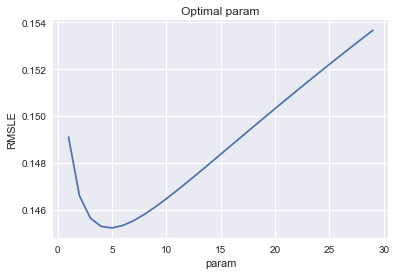

In [60]:
ridge_alpha_tuning(range(1,30), tr_X, tr_y, cv_ref, root_mean_squared_error)

i: 1 -> rmsle: 0.1694172872607855
i: 2 -> rmsle: 0.1589879108486278
i: 3 -> rmsle: 0.154166464937774
i: 4 -> rmsle: 0.15129868376586444
i: 5 -> rmsle: 0.14937918983961013
i: 6 -> rmsle: 0.14800302828868453
i: 7 -> rmsle: 0.14697186371104726
i: 8 -> rmsle: 0.1461757587799554
i: 9 -> rmsle: 0.1455482521896455
i: 10 -> rmsle: 0.1450464833199719
i: 11 -> rmsle: 0.14464139091392486
i: 12 -> rmsle: 0.1443124659454506
i: 13 -> rmsle: 0.14404475467818195
i: 14 -> rmsle: 0.14382705456115744
i: 15 -> rmsle: 0.14365077976364107
i: 16 -> rmsle: 0.143509221024493
i: 17 -> rmsle: 0.14339704728546462
i: 18 -> rmsle: 0.14330996083077435
i: 19 -> rmsle: 0.14324445288070947
i: 20 -> rmsle: 0.14319762669196284
i: 21 -> rmsle: 0.14316706710311047
i: 22 -> rmsle: 0.14315074271164194
i: 23 -> rmsle: 0.14314693141247092
i: 24 -> rmsle: 0.1431541629472698
i: 25 -> rmsle: 0.14317117403205865
i: 26 -> rmsle: 0.1431968729163656
i: 27 -> rmsle: 0.14323031110530823
i: 28 -> rmsle: 0.14327066058564714
i: 29 -> rmsl

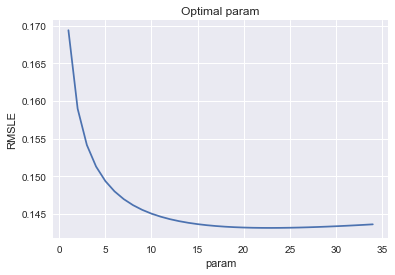

In [61]:
#RIDGE with features selected and interaction
ridge_alpha_tuning(range(1,35), tr_X_poly, tr_y, cv_ref, root_mean_squared_error)

i: 10.0 -> rmsle: 0.14314693141247092
i: 10.2 -> rmsle: 0.14314693141247092
i: 10.4 -> rmsle: 0.14314693141247092
i: 10.6 -> rmsle: 0.14314693141247092
i: 10.8 -> rmsle: 0.14314693141247092
i: 11.0 -> rmsle: 0.14314693141247092
i: 11.2 -> rmsle: 0.1442945748040026
i: 11.4 -> rmsle: 0.14804757294409762
i: 11.6 -> rmsle: 0.1624220790254346
i: 11.8 -> rmsle: 0.20048065180418345
i: 12.0 -> rmsle: 0.2778952533881965
best score: 0.14314693141247092 at 10.0


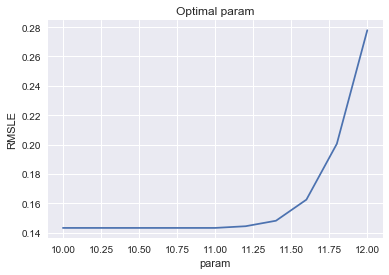

In [62]:
threshold_tuning(np.linspace(10, 12, 11), Ridge(alpha=23), 
                 tr_X_poly, tr_y, cv_ref, root_mean_squared_error)

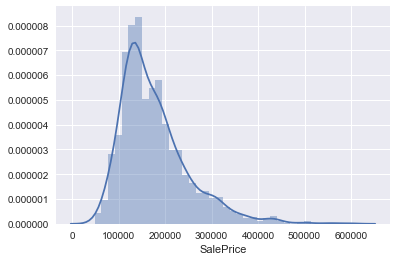

In [73]:
#train
ridge = Ridge(alpha=23)
ridge.fit(tr_X_poly, tr_y)

#predict
pred_te_y = pd.DataFrame({"Id": te_X.index, 
                          "SalePrice": ridge.predict(
                              bring_interaction(te_X.loc[:, feature_selected])).reshape((te_X.shape[0],))})
pred_te_y.loc[pred_te_y.SalePrice < 10.0, "SalePrice"] = 10.0
pred_te_y.loc[:, "SalePrice"] = pred_te_y.loc[:, "SalePrice"].apply(lambda x: np.e**x)

#save submission
description="alpha" + str(23) + "_threshold_" + str(10)
pred_te_y.to_csv("submission/ridge_set{}_{}.csv".format(set_ver, description), index=False)
ax = sns.distplot(pred_te_y.SalePrice)

### REGULARIZATION: LASSO (모든 feature의 영향을 조심씩 줄여서 노이즈 없애기)

In [83]:
def lasso_alpha_tuning(iterable_range, X, y, cv_table, validation_func, 
                 threshold=min_log_saleprice):
    rmsle = []
    best_param = 0 
    best_score = 1
    for i in iterable_range:
        regr = Lasso(alpha=i)
        cv_scores = cross_validate(
            regr, X, y, cv_table, validation_func, threshold)
        mean_cv_score = np.mean(cv_scores)
        rmsle.append(mean_cv_score)
        if mean_cv_score < best_score:
            best_score = mean_cv_score
            best_param = i
        print("i: {} -> rmsle: {}".format(i, mean_cv_score))
    print("best score: {} at {}".format(best_score, best_param))
    plt.plot(iterable_range, rmsle)
    plt.title("Optimal param")
    plt.xlabel("param")
    plt.ylabel("RMSLE")

i: 0.0001 -> rmsle: 0.15609743094131895
i: 0.0002 -> rmsle: 0.14997196730515353
i: 0.00030000000000000003 -> rmsle: 0.1470797643791649
i: 0.0004 -> rmsle: 0.14567729701775972
i: 0.0005 -> rmsle: 0.14500578799653505
i: 0.0006000000000000001 -> rmsle: 0.1441597841918686
i: 0.0007000000000000001 -> rmsle: 0.14324456058372434
i: 0.0008 -> rmsle: 0.14264427439095523
i: 0.0009000000000000001 -> rmsle: 0.14230505262432427
i: 0.001 -> rmsle: 0.14220930720448374
i: 0.0011 -> rmsle: 0.1423416573601845
i: 0.0012000000000000001 -> rmsle: 0.14267018467167203
i: 0.0013000000000000002 -> rmsle: 0.14312542861043714
i: 0.0014000000000000002 -> rmsle: 0.14360272367076124
i: 0.0015 -> rmsle: 0.1441161677936988
i: 0.0016 -> rmsle: 0.1446705619044287
i: 0.0017000000000000001 -> rmsle: 0.14525452033530445
i: 0.0018000000000000002 -> rmsle: 0.14583982249393507
i: 0.0019000000000000002 -> rmsle: 0.14644062169310385
i: 0.002 -> rmsle: 0.1470511175900541
i: 0.0021 -> rmsle: 0.14768413392691548
i: 0.0022 -> rmsl

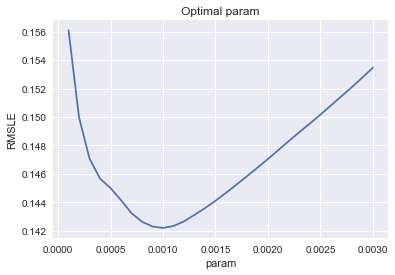

In [136]:
lasso_alpha_tuning(np.linspace(0.0001, 0.003, 30), tr_X, tr_y, cv_ref, root_mean_squared_error)

/Users/heekyungyoon/.pyenv/versions/3.6.0/envs/venv36_houseprice/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


i: 0.0001 -> rmsle: 0.160969718941731
i: 0.0002 -> rmsle: 0.1544307634454247
i: 0.00030000000000000003 -> rmsle: 0.15078754375468734
i: 0.0004 -> rmsle: 0.14862636252534117
i: 0.0005 -> rmsle: 0.14744338999848283
i: 0.0006000000000000001 -> rmsle: 0.14642531947958295
i: 0.0007000000000000001 -> rmsle: 0.14574222126042097
i: 0.0008 -> rmsle: 0.14533231162435528
i: 0.0009000000000000001 -> rmsle: 0.14512720571162924
i: 0.001 -> rmsle: 0.14507361782850228
i: 0.0011 -> rmsle: 0.145200602940759
i: 0.0012000000000000001 -> rmsle: 0.14538889055851184
i: 0.0013000000000000002 -> rmsle: 0.14558304397446895
i: 0.0014000000000000002 -> rmsle: 0.14579836174516192
i: 0.0015 -> rmsle: 0.1460498044668287
i: 0.0016 -> rmsle: 0.14632643215529761
i: 0.0017000000000000001 -> rmsle: 0.1466483689248857
i: 0.0018000000000000002 -> rmsle: 0.14697622464419383
i: 0.0019000000000000002 -> rmsle: 0.14731991265887512
i: 0.002 -> rmsle: 0.14770709683327496
i: 0.0021 -> rmsle: 0.14812168511532717
i: 0.0022 -> rmsle

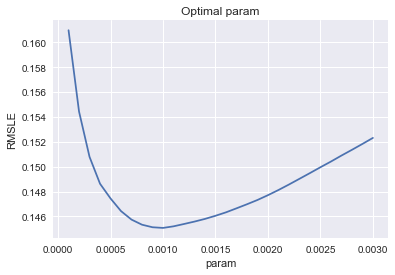

In [137]:
lasso_alpha_tuning(np.linspace(0.0001, 0.003, 30), tr_X_poly, tr_y, cv_ref, root_mean_squared_error)

i: 10.0 -> rmsle: 0.14507361782850228
i: 10.2 -> rmsle: 0.14507361782850228
i: 10.4 -> rmsle: 0.14507361782850228
i: 10.6 -> rmsle: 0.14507361782850228
i: 10.8 -> rmsle: 0.14507361782850228
i: 11.0 -> rmsle: 0.14532057408523916
i: 11.2 -> rmsle: 0.14638481693482142
i: 11.4 -> rmsle: 0.1506694175960833
i: 11.6 -> rmsle: 0.1652712985012763
i: 11.8 -> rmsle: 0.20347739896646325
i: 12.0 -> rmsle: 0.28022612085152915
best score: 0.14507361782850228 at 10.0


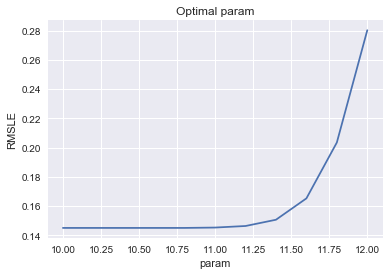

In [139]:
threshold_tuning(np.linspace(10, 12, 11), Lasso(alpha=0.001), 
                 tr_X_poly, tr_y, cv_ref, root_mean_squared_error)